In [1]:
import pandas as pd
import numpy as np

from numpy.linalg import norm
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

import itertools
import random
import pickle

import json

import matplotlib.pyplot as plt
%matplotlib inline

Extract network features and use them to compute similarity between 20 seeds in the <b>finance domain</b> and <b>random users</b>.

The idea is to keep part of the seeds as seeds and the other part as good candidates, while all the random users are bad candidates. In this way it is possible to assess automatically the goodness of the method, because the groundtruth is already validated.

Steps to follow:
1. Split seeds in candidates and effective seeds (10/10) - <b> define shared list of combinations </b>
2. Compute centroid with effective seeds
3. Rank random users and candidates with respect to the centroid
4. Compute #good candidates extracted at each level of ranking and plot the resulting line against the random ranking (linear)
5. Iterate with different splits
6. Compare with respect to the fingerprint method

In [2]:
def candidatesRanking(candidates, centroid, features):
    #centroid_v = np.array(centroid[features])
    
    output = pd.DataFrame()
    
    output['username'] = candidates['username']
    output['id_user'] = candidates['id_user']
    
    # ranking based on distance similarity
    # output['distance'] = candidates.apply(lambda x: norm(np.array(x[features]) - centroid), axis=1)
    # output['similarity'] = output.apply(lambda x: 1/(1+x['distance']), axis=1)
    
    # ranking based on cosine similarity
    output['similarity'] = candidates.apply(lambda x: cosine_similarity(
                                            np.array(x[features]).reshape(1, -1), centroid.reshape(1, -1)
                                            ), axis=1)
    
    output.sort_values(by='similarity', ascending=False, inplace=True)
    
    # reset_index -> index+1 becomes the ranking
    output.reset_index(inplace=True)
    
    return output

In [3]:
def computeCentroid(seeds, normheader):
    arrays = [np.array(x[normheader]) for index, x in seeds.iterrows()]
    #print arrays
    return np.sum(arrays, axis=0)/seeds.shape[0]

In [4]:
def cumulativeGoodCandidates(ranking):
    cumulative = []
    n_good_candidates = 0
    
    for index, ranked_user in ranking.iterrows():
        if ranked_user['good'] == True:
            n_good_candidates = n_good_candidates + 1
        cumulative.append(n_good_candidates)
        
    return np.array(cumulative)

In [5]:
def plotData(seeds, candidates, components, centroids = None):
    x = components[0]
    y = components[1]
    
    plt.figure(figsize=(12,12))
    plt.scatter(candidates[x], candidates[y], marker='.', s=40, lw=0, alpha=0.7)
    plt.scatter(seeds[x], seeds[y], marker='x', color='red')
    
    if centroids is not None:
        for c in centroids:
            plt.scatter(c[0], c[1], marker='o', color='black')

In [6]:
def computeSimDistribution(ranking, float_prec):
    prec_str = '%.{}f'.format(float_prec)
    ranking['truncated'] = ranking.apply(lambda x: float(prec_str%(x['similarity'])), axis=1)
    
    y = ranking.groupby(by='truncated').count().reset_index()[['truncated','similarity']]
    y.columns = ['sim','freq']
    y.sort_values(by='sim', inplace=True)
    
    return y

In [7]:
header = ['{}'.format(i) for i in range(1,9)]

# Run tests with fixed combinations

In [8]:
allseeds = list(map(str, pd.read_csv('../data-seed/finance_20/user.csv', sep='\t')['screen_name']))
combinations = json.load(open('combinations.json', 'rb'))

In [9]:
allseeds

['laurenlacapra',
 'lamonicabuzz',
 'bill_easterly',
 'fgoria',
 'firoozye',
 'ezraklein',
 'economistmeg',
 'rencapman',
 'keithmccullough',
 'justinwolfers',
 'howardlindzon',
 'economisthulk',
 'reformedbroker',
 'reinman_mt',
 'eu_eurostat',
 'dsquareddigest',
 'faulljonathan',
 'queen_europe',
 'kathylienfx',
 'katie_martin_fx']

In [10]:
len(combinations)

50

In [11]:
combinations['0']

['bill_easterly',
 'firoozye',
 'ezraklein',
 'economisthulk',
 'reformedbroker',
 'eu_eurostat',
 'faulljonathan',
 'queen_europe',
 'kathylienfx',
 'katie_martin_fx']

In [12]:
domain = 'finance_20'
datapath = '../data-seed/{}/'.format(domain)
path = 'random-test/test-network-features/'

In [13]:
# define function to apply the same analysis to all the datasets
def computePerformance(allseeds, comb, data, network_type):
    
    candidates_ranking = {}
    for u in allseeds:
        candidates_ranking[u] = []

    # store everyone ranking to check if, on average, some interesting user comes up
    all_ranking = {}
    for u in list(data['username']):
        all_ranking[u] = []
    
    ysum = np.zeros(data.shape[0] - 10)
    prec_20 = []
    prec_10 = []
    rankings = {}
    matrix = []
    
    for c in comb:
        effective_seeds = [x.lower() for x in comb[c]] #lower case for usernames
        good_candidates = list(set(allseeds)-(set(effective_seeds)))
       
        seedsVectors = data[data['username'].isin(effective_seeds)]
        centroid = computeCentroid(seedsVectors, header)
        candidates = data[~data['username'].isin(effective_seeds)]

        r = candidatesRanking(candidates, centroid, header)
        r['good'] = r.apply(lambda x: True if x['username'] in good_candidates else False, axis=1)
        rankings[c] = r['username'].values

        y = cumulativeGoodCandidates(r)
        ysum = ysum + y
        matrix.append([y[i-1]/i for i in range(1, len(y))]) # compute precision and then derive std

        for index, candidate in r[r['good'] == True].iterrows():
            username = candidate['username']
            candidates_ranking[username].append(index+1)

        for index, candidate in r.iterrows():
            username = candidate['username']
            all_ranking[username].append(index+1)

        prec_20.append(cumulativeGoodCandidates(r[:20])[19])
        prec_10.append(cumulativeGoodCandidates(r[:10])[9])

    m = np.array(matrix)
    std_dev = np.std(m, axis=0)
    
    y_avg = ysum.astype(float)/len(combinations)
    
    plt.figure(figsize=(14,8))
    plt.title('Cumulative good candidates for {} network'.format(network_type))
    plt.ylabel('#good candidates')
    plt.xlabel('ranking position')

    plt.plot(y_avg)
    plt.plot([0, len(y_avg)],[0, 10], linestyle='--', color='black')
    plt.xlim(xmin=1)

    plt.yticks(range(1,11))
    plt.grid(True)
    
    print ('Average P@20: {:.2f}'.format(np.mean(prec_20)))
    print ('Average P@10: {:.2f}'.format(np.mean(prec_10)))
              
    return [y_avg, std_dev, candidates_ranking, rankings]

In [14]:
test = 1

seed_data = pd.read_csv(datapath+'/user.csv', sep='\t')
seed_data['usertype'] = 'seed'

# test ids needed to filter the mentioned/following/followed users (they are not included in the ranking)
testusers = pd.read_csv('../data-random/user.csv', sep='\t')

In [15]:
voc_rank = pickle.load(open('../../fingerprints/finance_best20_vocabulary.pkl' , 'rb'))

In [16]:
voc_rank[0]

array(['economistmeg', 'dsquareddigest', 'adam', 'rencapman', 'cbrumelle',
       'lamonicabuzz', 'heppy', 'fgoria', 'justinwolfers',
       'jennythomasson', 'michalp', 'laurenlacapra', 'cw', 'brothersloth',
       'dunstan', 'joe_sixpack', 'vanhoosear', 'chrisfralic', 'alissa',
       'jodopod'], dtype=object)

In [17]:
voc_complete = pickle.load(open('../../fingerprints/finance_complete_vocabulary.pkl' , 'rb'))
len(voc_complete[0])

96

## Hashtags Network Test - 1

Average P@20: 1.84
Average P@10: 1.14


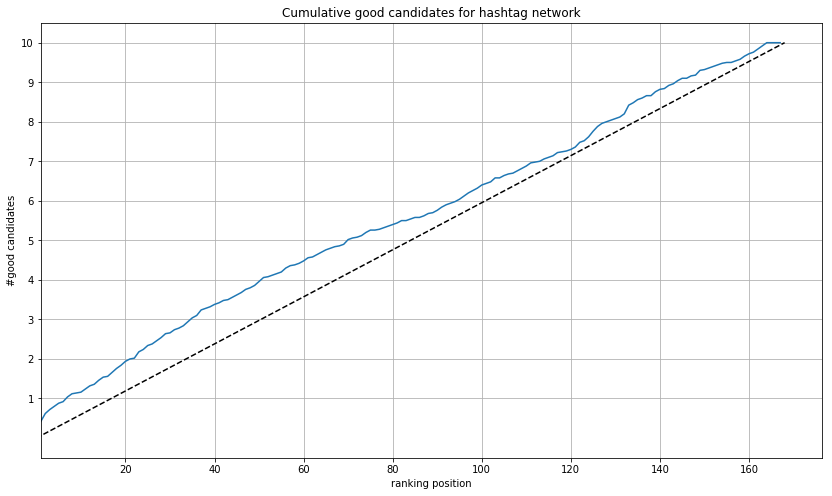

In [18]:
# features file reading and metadata inclusion
userdata = pd.read_csv(path+'h_network_{}_nodes.csv'.format(test), sep='\t') # match graph id and user instance
data = pd.read_csv(path+'h_network_{}.emb'.format(test), sep=' ', header=None, skiprows=1)
data = userdata.merge(data, left_on='id', right_on=0)
data.drop(0, inplace=True, axis=1)
data.columns = ['id_graph','username','id_user','usertype']+header

data = data[data['usertype'].isin(['seed','user'])]
data.reset_index(inplace=True)

perf_tag, std_tag, candidate_rank, all_rank = computePerformance(allseeds, combinations, data, 'hashtag')

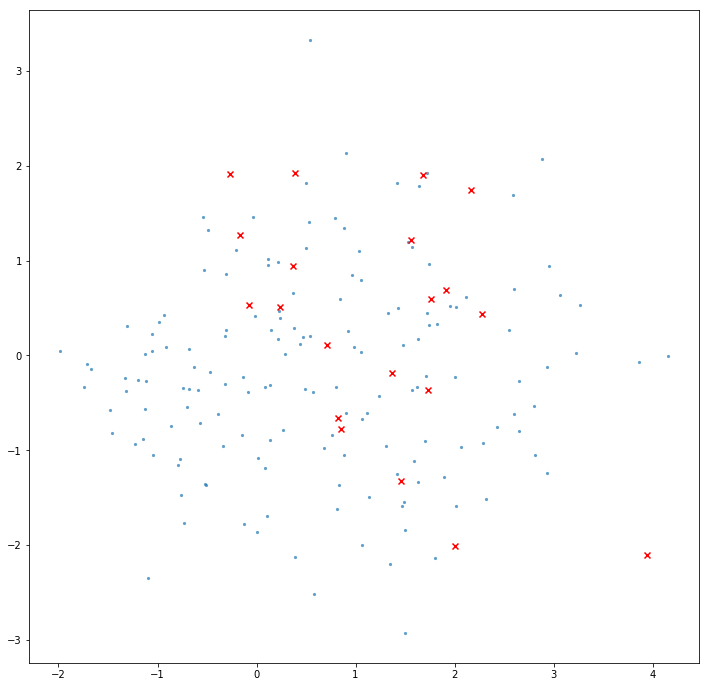

In [16]:
plotData(data[data['usertype'] == 'seed'], data[data['usertype']=='user'], header)

## Mention Network Test - 1

Average P@20: 4.98
Average P@10: 3.54


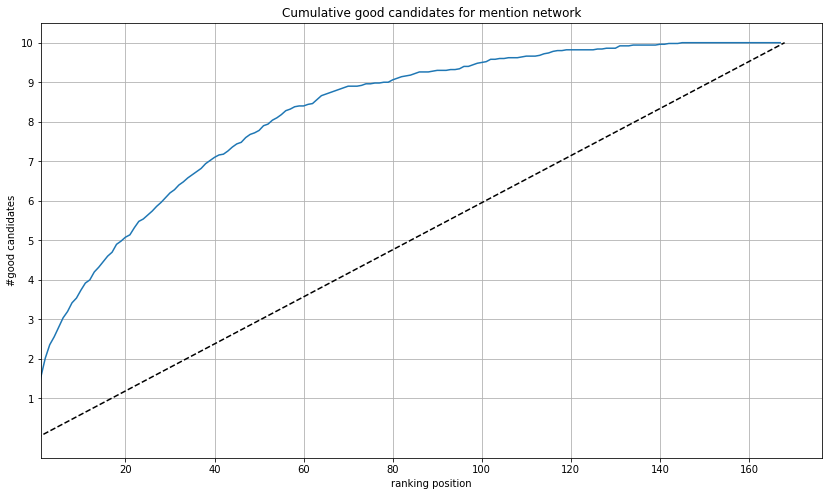

In [19]:
# features file reading and metadata inclusion
userdata = pd.read_csv(path+'m_network_{}_nodes.csv'.format(test), sep='\t') # match graph id and user instance
userdata = userdata[userdata['id_node'].isin(['seed', 'user'])]

data = pd.read_csv(path+'m_network_{}.emb'.format(test), sep=' ', header=None, skiprows=1)
data = userdata.merge(data, left_on='id', right_on=0)

data.drop(0, inplace=True, axis=1)
data.columns = ['id_graph','username','id_user','usertype']+header
data['id_user'] = data['id_user'].astype(int)

# keeps only seeds and test users for the evaluation
t1_users = testusers[testusers['n_test'] == test][['id_user', 'screen_name']].drop_duplicates()
t1_users['usertype'] = 'user'
data = data.merge(pd.concat([seed_data[['id_user', 'screen_name', 'usertype']], t1_users]), on='id_user')

perf_mention, std_men, candidate_rank, all_rank = computePerformance(allseeds, combinations, data, 'mention')

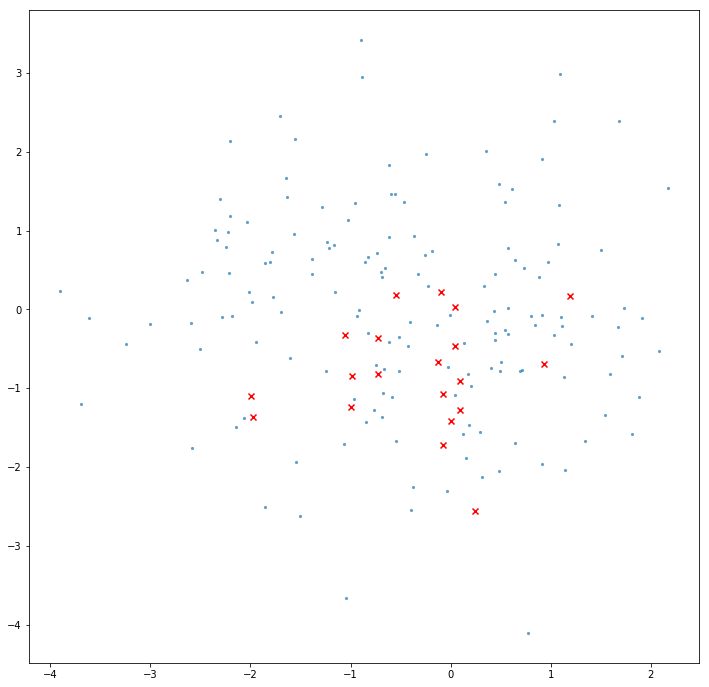

In [18]:
plotData(data[data['usertype_x'] == 'seed'], data[data['usertype_x']=='user'], header)

## Following Network Test - 1

Average P@20: 7.92
Average P@10: 5.98


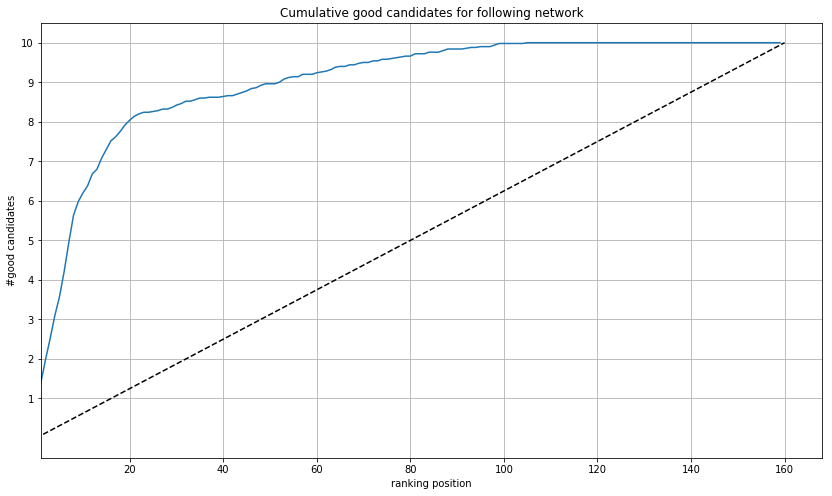

In [20]:
# features file reading and metadata inclusion
userdata = pd.read_csv(path+'social_network_{}_following_nodes.csv'.format(test), sep='\t')
data = pd.read_csv(path+'social_network_{}_following.emb'.format(test), sep=' ', header=None, skiprows=1)
data = userdata.merge(data, left_on='id', right_on=0)
data.drop(0, inplace=True, axis=1)

# need to add usernames, too and filter the mentioned users that should not be included
t1_users = testusers[testusers['n_test'] == test][['id_user', 'screen_name']].drop_duplicates()
t1_users['usertype'] = 'user'
data = data.merge(pd.concat([seed_data[['id_user', 'screen_name', 'usertype']], t1_users]), on='id_user')

data.columns = ['id_graph','followers','following','id_user']+header+['username', 'usertype']

perf_following, std_following, candidates_ranking, all_ranking = computePerformance(allseeds, combinations, data, 'following')

7.02


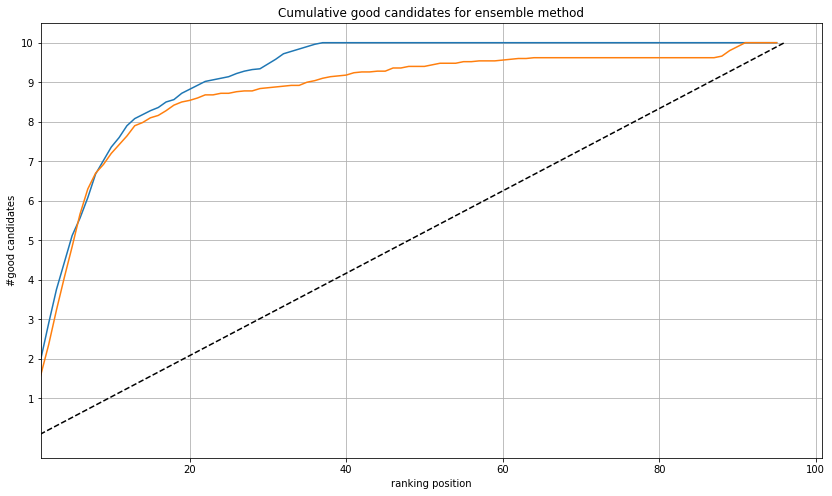

In [23]:
# merging the rankings shows that the two methods extract different good candidates
# need to find a way to programmatically merge the two lists in a unique better list

topK = 20 # topK = 30, P@10 = 8.02

ensemble_p10 = 0
ysum = 0
ysum_voc = 0
for i in range(50):
    good_candidates = set(set(allseeds)-(set(combinations[str(i)])))
        
    voc_r = pd.DataFrame([u.lower() for u in voc_complete[i]]).reset_index()
    graph_r = pd.DataFrame(all_ranking[str(i)]).reset_index()
    merge_r = voc_r.merge(graph_r, on=0, how='inner')#.fillna(0)
    merge_r['ranking'] = merge_r.apply(lambda x: x['index_x']+x['index_y'], axis=1)
    merge_r = merge_r.sort_values(by='ranking', ascending=True)
    
    merge_r['good'] = merge_r.apply(lambda x: True if x[0] in good_candidates else False, axis=1)
    voc_r['good'] = voc_r.apply(lambda x: True if x[0] in good_candidates else False, axis=1)
    
    y = cumulativeGoodCandidates(merge_r)
    y_voc = cumulativeGoodCandidates(voc_r)
    ysum = ysum + y
    ysum_voc += y_voc
    p10 = y[9]
    
    ensemble_p10 += p10
    
print (ensemble_p10/50)

ensemble = ysum.astype(float)/50
voc = ysum_voc.astype(float)/50
plt.figure(figsize=(14,8))
plt.title('Cumulative good candidates for ensemble method')
plt.ylabel('#good candidates')
plt.xlabel('ranking position')

plt.plot(ensemble)
plt.plot(voc)
plt.plot([0, len(ysum)],[0, 10], linestyle='--', color='black')
plt.xlim(xmin=1)

plt.yticks(range(1,11))
plt.grid(True)

In [19]:
json_data = {}
for key in all_ranking:
    json_data[key] = list(all_ranking[key])

In [20]:
with open('finance_ranking_cosine.json', 'w') as fp:
    json.dump(json_data, fp)

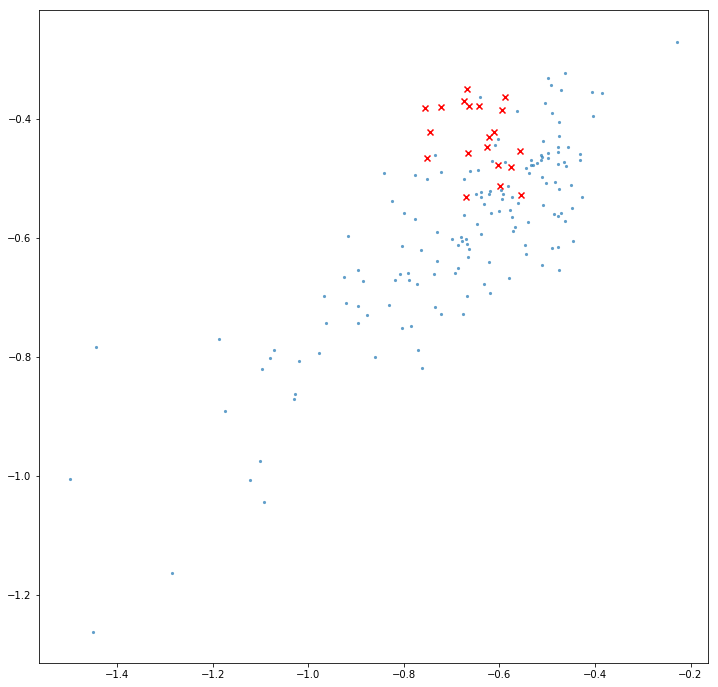

In [20]:
plotData(data[data['usertype'] == 'seed'], data[data['usertype']=='user'], header)

In [21]:
# these are missing because they have no following, so they are not present in the network
set(testusers[testusers['n_test']==1]['id_user']) - set(data['id_user'])

{519,
 3077,
 4562,
 9258192,
 9656292,
 19812908,
 36958712,
 62985293,
 193280501,
 860061325}

## Followers Network Test - 1

Average P@20: 6.84
Average P@10: 4.82


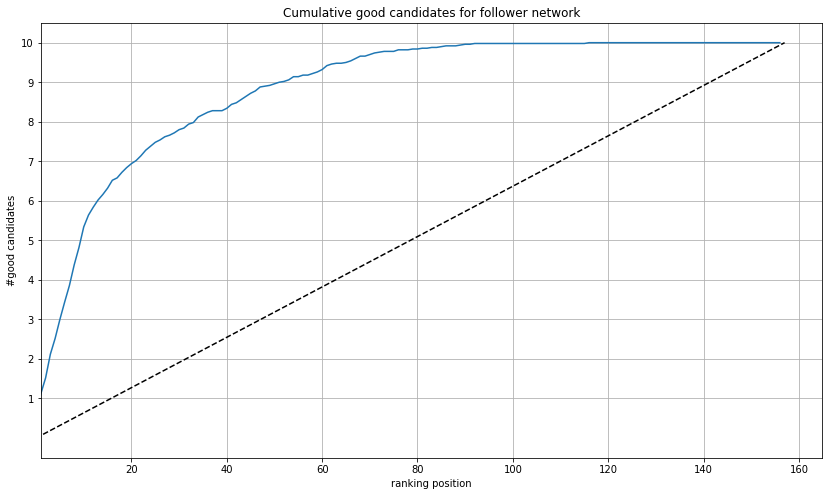

In [21]:
# features file reading and metadata inclusion
userdata = pd.read_csv(path+'social_network_{}_follower_nodes.csv'.format(test), sep='\t')
data = pd.read_csv(path+'social_network_{}_follower.emb'.format(test), sep=' ', header=None, skiprows=1)
data = userdata.merge(data, left_on='id', right_on=0)
data.drop(0, inplace=True, axis=1)

# need to add usernames, too and filter the mentioned users that should not be included
t1_users = testusers[testusers['n_test'] == test][['id_user', 'screen_name']].drop_duplicates()
t1_users['usertype'] = 'user'
data = data.merge(pd.concat([seed_data[['id_user', 'screen_name', 'usertype']], t1_users]), on='id_user')

data.columns = ['id_graph','followers','following','id_user']+header+['username', 'usertype']

perf_follower, std_followers, candidates_ranking, all_ranking = computePerformance(allseeds, combinations, data, 'follower')

In [22]:
topK = 10
ensemble_p10 = 0
v_p10 = 0
g_p10 = 0

for i in range(50):
    voc_r = set([u.lower() for u in voc_rank[i][:topK]])
    graph_r = set(all_ranking[str(i)][:topK])
    
    good_candidates = set(set(allseeds)-(set(combinations[str(i)])))

    pred_v = set([u for u in voc_r if u in good_candidates])
    pred_g = set([u for u in graph_r if u in good_candidates])
    diff = pred_v.difference(pred_g)
    
    #if len(diff)>0:
    #    print(i, diff, len(pred_v.union(pred_g)))
    
    ensemble_p10 += len(pred_v.union(pred_g))
    v_p10 += len(pred_v)
    g_p10 += len(pred_g)
                        
print('VOCABULARY - Average P@10: {}'.format(v_p10/50))
print('GRAPH - Average P@10: {}'.format(g_p10/50))
print('ENSEMBLE - Max Average P@10: {}'.format(ensemble_p10/50))

VOCABULARY - Average P@10: 6.92
GRAPH - Average P@10: 6.3
ENSEMBLE - Max Average P@10: 8.66


8.06


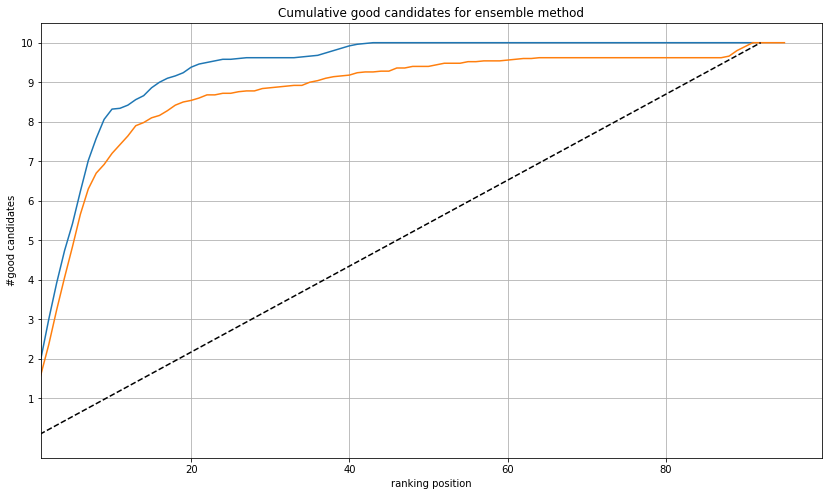

In [23]:
# merging the rankings shows that the two methods extract different good candidates
# need to find a way to programmatically merge the two lists in a unique better list

topK = 20 # topK = 30, P@10 = 8.02

ensemble_p10 = 0
ysum = 0
ysum_voc = 0
for i in range(50):
    good_candidates = set(set(allseeds)-(set(combinations[str(i)])))
        
    voc_r = pd.DataFrame([u.lower() for u in voc_complete[i]]).reset_index()
    graph_r = pd.DataFrame(all_ranking[str(i)]).reset_index()
    merge_r = voc_r.merge(graph_r, on=0, how='inner')#.fillna(0)
    merge_r['ranking'] = merge_r.apply(lambda x: x['index_x']+x['index_y'], axis=1)
    merge_r = merge_r.sort_values(by='ranking', ascending=True)
    
    merge_r['good'] = merge_r.apply(lambda x: True if x[0] in good_candidates else False, axis=1)
    voc_r['good'] = voc_r.apply(lambda x: True if x[0] in good_candidates else False, axis=1)
    
    y = cumulativeGoodCandidates(merge_r)
    y_voc = cumulativeGoodCandidates(voc_r)
    ysum = ysum + y
    ysum_voc += y_voc
    p10 = y[9]
    
    ensemble_p10 += p10
    
print (ensemble_p10/50)

ensemble = ysum.astype(float)/50
voc = ysum_voc.astype(float)/50
plt.figure(figsize=(14,8))
plt.title('Cumulative good candidates for ensemble method')
plt.ylabel('#good candidates')
plt.xlabel('ranking position')

plt.plot(ensemble)
plt.plot(voc)
plt.plot([0, len(ysum)],[0, 10], linestyle='--', color='black')
plt.xlim(xmin=1)

plt.yticks(range(1,11))
plt.grid(True)

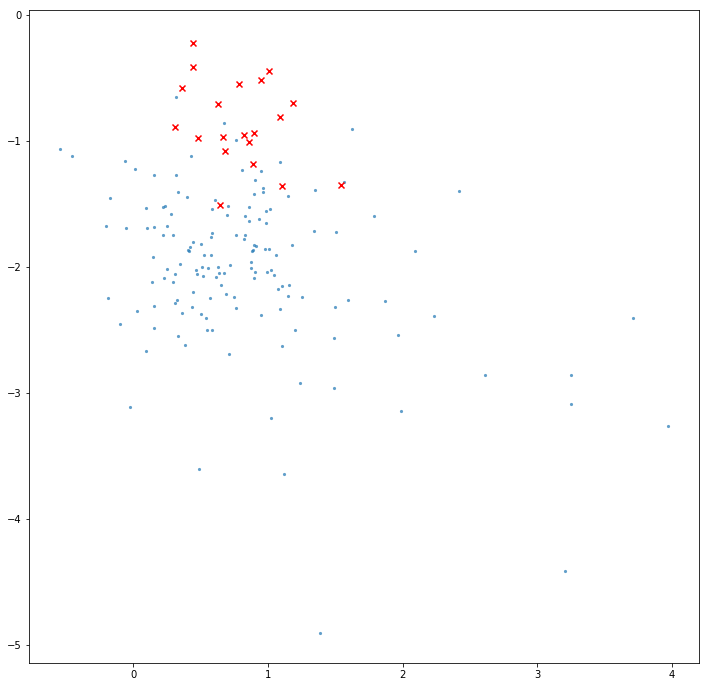

In [23]:
plotData(data[data['usertype'] == 'seed'], data[data['usertype']=='user'], header)

In [23]:
json_data = {}
for key in all_ranking:
    json_data[key] = list(all_ranking[key])

In [24]:
with open('finance_ranking.json', 'w') as fp:
    json.dump(json_data, fp)

## Followers + Following Network

Average P@20: 7.02
Average P@10: 4.72


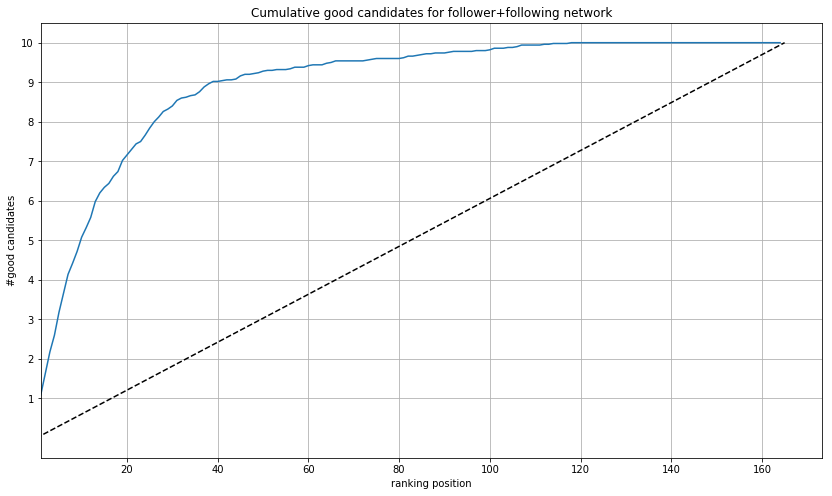

In [22]:
# features file reading and metadata inclusion
userdata = pd.read_csv(path+'social_network_{}_complete_nodes.csv'.format(test), sep='\t')
data = pd.read_csv(path+'social_network_{}_complete.emb'.format(test), sep=' ', header=None, skiprows=1)
data = userdata.merge(data, left_on='id', right_on=0)
data.drop(0, inplace=True, axis=1)
data['id_user'] = data['id_user'].astype(str)

# need to add usernames, too and filter the mentioned users that should not be included
t1_users = testusers[testusers['n_test'] == test][['id_user', 'screen_name']].drop_duplicates()
t1_users['usertype'] = 'user'
all_u = pd.concat([seed_data[['id_user', 'screen_name', 'usertype']], t1_users])
all_u['id_user'] = all_u['id_user'].astype(str)

data_complete = data.merge(all_u, on='id_user')

data_complete.columns = ['id_graph','followers','following','id_user']+header+['username', 'usertype']

perf_complete, std_complete, candidates_ranking, all_ranking = computePerformance(allseeds, combinations, data_complete, 'follower+following')

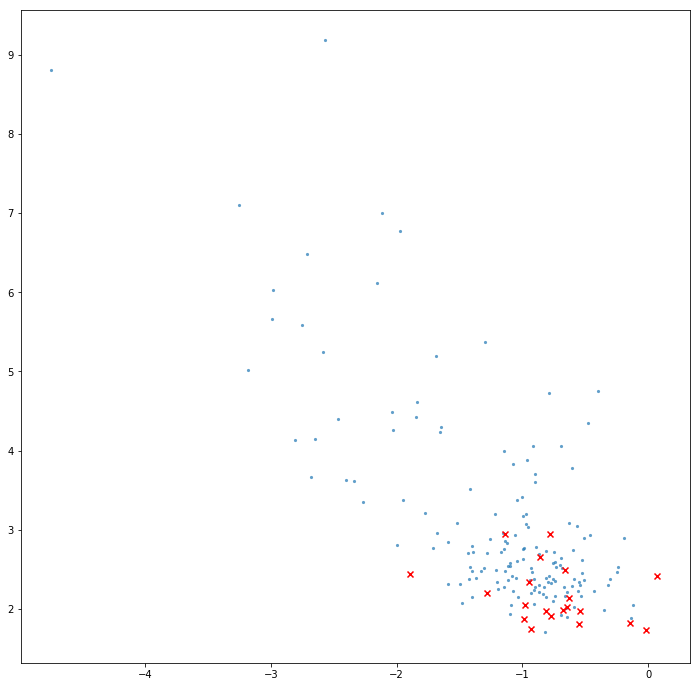

In [25]:
plotData(data_complete[data_complete['usertype'] == 'seed'], data_complete[data_complete['usertype']=='user'], header)

## Reduced Social Network

Average P@20: 6.00
Average P@10: 3.62


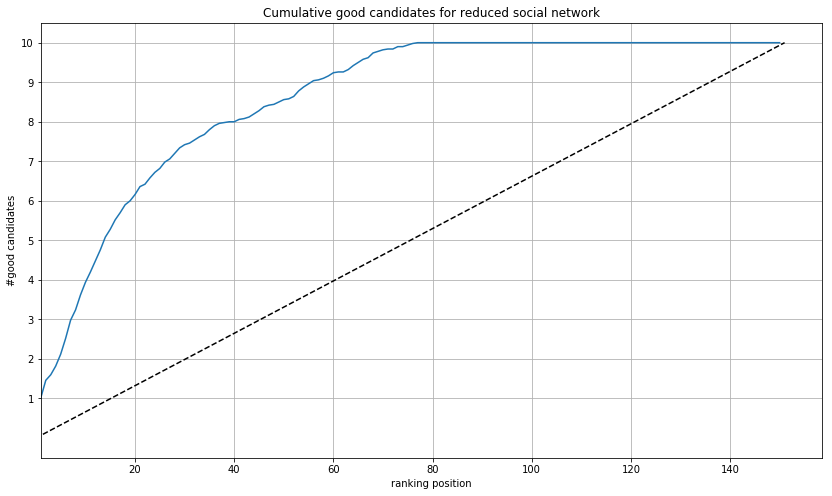

In [23]:
# features file reading and metadata inclusion
header = ['{}'.format(i) for i in range(1,5)]
userdata = pd.read_csv(path+'social_reduced_nodes.csv', sep='\t')
data = pd.read_csv(path+'social_network_reduced_weighted.emb', sep=' ', header=None, skiprows=1)
data = userdata.merge(data, left_on='id', right_on=0)
data.drop(0, inplace=True, axis=1)
data['id_user'] = data['id_user'].astype(str)

# need to add usernames, too and filter the mentioned users that should not be included
t1_users = testusers[testusers['n_test'] == test][['id_user', 'screen_name']].drop_duplicates()
t1_users['usertype'] = 'user'
all_u = pd.concat([seed_data[['id_user', 'screen_name', 'usertype']], t1_users])
all_u['id_user'] = all_u['id_user'].astype(str)

data_complete = data.merge(all_u, on='id_user')

data_complete.columns = ['id_graph','id_user','usertype']+header+['username', 'usertype_x']

perf_social_red, std_reduced, candidates_ranking, all_ranking = computePerformance(allseeds, combinations, data_complete, 'reduced social')

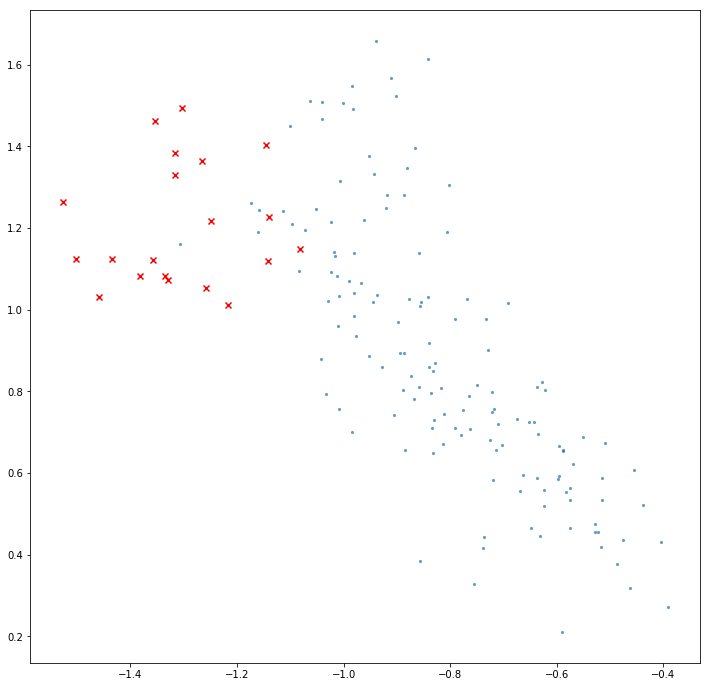

In [25]:
plotData(data_complete[data_complete['usertype'] == 'seed'], data_complete[data_complete['usertype_x']=='user'], header)

## Performance Comparison

In [24]:
print (len(perf_tag), len(perf_mention), len(perf_following), len(perf_follower), len(perf_complete), len(perf_social_red))

168 168 160 157 165 151


In [25]:
pf_1 = np.append(perf_following, [10.]*8)
pf_2 = np.append(perf_follower, [10.]*13)
pf_3 = np.append(perf_complete, [10.]*3)
pf_4 = np.append(perf_social_red, [10.]*17)

In [26]:
std_1 = np.append(std_following, [0.]*8).reshape(-1, 1)
std_2 = np.append(std_followers, [0.]*13).reshape(-1, 1)
std_3 = np.append(std_complete, [0.]*3).reshape(-1, 1)
std_4 = np.append(std_reduced, [0.]*17).reshape(-1, 1)

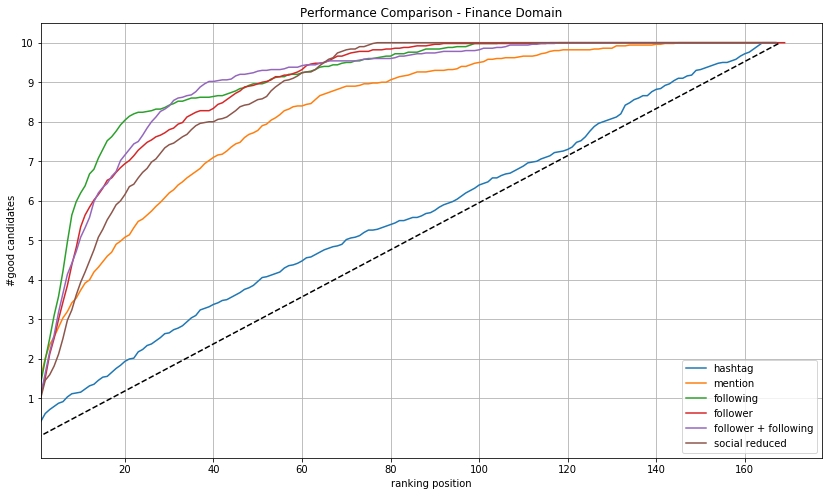

In [29]:
plt.figure(figsize=(14,8))

plt.plot(perf_tag, label='hashtag')
plt.plot(perf_mention, label='mention')
plt.plot(pf_1, label='following')
plt.plot(pf_2, label='follower')
plt.plot(pf_3, label='follower + following')
plt.plot(pf_4, label='social reduced')
# plt.plot(ensemble, label='combination')
plt.plot([0, len(perf_tag)], [0, 10], linestyle='--', color='black')

plt.legend()
plt.title('Performance Comparison - Finance Domain')
plt.ylabel('#good candidates')
plt.xlabel('ranking position')

plt.xlim(xmin=1)
plt.yticks(range(1,11))
plt.grid(True)

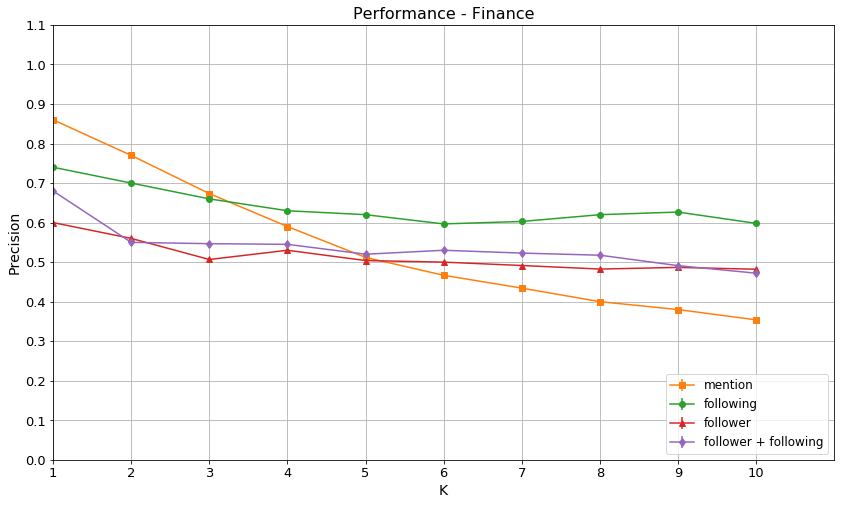

In [29]:
# paper image

plt.figure(figsize=(14,8))

K = 10 
x = range(K)

l = plt.plot(perf_tag[:K], label='hashtag')
l.pop(0).remove()

prec_m = [perf_mention[i-1]/i for i in range(1, K+1)]
#plt.plot(prec_m, color='black', linestyle='-')
plt.errorbar(x, prec_m, yerr=[0.]*K, label='mention', fmt='s', ls='-') # std_men[:K].reshape(-1,1)

#plt.plot(pf_1[:K], label='following')
prec_following = [pf_1[i-1]/i for i in range(1, K+1)]
plt.errorbar(x, prec_following, yerr=[0.]*K, label='following', fmt='o', ls='-') # std_1[:K]

#plt.plot(pf_2[:K], label='follower')
prec_follower = [pf_2[i-1]/i for i in range(1, K+1)]
plt.errorbar(x, prec_follower, yerr=[0.]*K, label='follower', fmt='^', ls='-') # std_2[:K]

#plt.plot(pf_3[:K], label='follower + following')
prec_complete = [pf_3[i-1]/i for i in range(1, K+1)]
plt.errorbar(x, prec_complete, yerr=[0.]*K, label='follower + following', fmt='d', ls='-') # std_3[:K]
# plt.plot(pf_4[:K], label='social reduced')
# plt.plot([0, 20], [0, 10], linestyle='--', color='black')


plt.legend(loc=4, fontsize='large')
plt.title('Performance - Finance', fontsize=16)
plt.ylabel('Precision', fontsize=14)
plt.xlabel('K', fontsize=14)

plt.xlim(xmin=1, xmax=K)
plt.ylim(ymin=0, ymax=1.1)
plt.yticks(np.arange(0, 1.2, 0.1))
plt.xticks(range(0, K, int(K/10)), [str(i+1) for i in range(K)])
plt.tick_params(labelsize=13)

plt.grid(True)

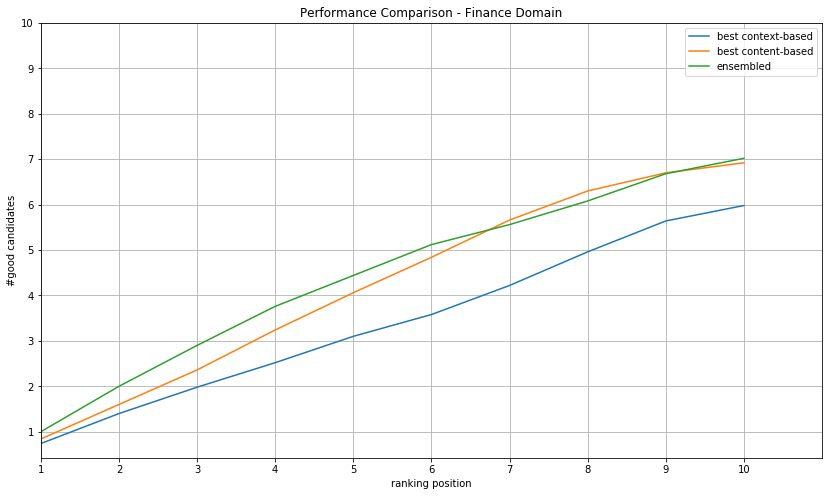

In [32]:
# paper figure

plt.figure(figsize=(14,8))
K = 10


plt.plot(pf_1[:K], label='best context-based')
plt.plot(voc[:K], label='best content-based')
plt.plot(ensemble[:K], label='ensembled')
#plt.plot([0, 20], [0, 10], linestyle='--', color='black')


plt.legend()
plt.title('Performance Comparison - Finance Domain')
plt.ylabel('#good candidates')
plt.xlabel('ranking position')

plt.xlim(xmin=1, xmax=K)
plt.yticks(range(1, K+1))
plt.xticks(range(0, 10, int(K/10)), [str(i+1) for i in range(K)])
plt.grid(True)